# Addestramento modello convolutivo
Nel seguente notebook verranno addestrati i modelli presenti nel notebook [Modello convolutivo](Modello_convolutivo.ipynb), utilizzando come tipo di dati i **filterbanks** e gli **mfcc**. Ci aspettiamo di ottenere risultati differenti e sarà interessante analizzare le differenze.

In [1]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.fftpack as scipy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# per il modello con estensione .onnx
import onnxruntime as rt
import tf2onnx
import onnx

## Classe per la conversione del dataset
Vista la quantità di opzioni disponibili, si è scelto di creare una classe. Essa contiene il metodo `convert` in grado di trasformare il dataset di audio in spettrogrammi, filterbanks, o mfcc in base all'argomento dato in input. Gli altri metodi presenti al suo interno sono già stati spiegati e ne abbiamo visto l'utilizzo nei precedenti notebook. 

In [2]:
class DatasetConverter:
    def __init__(self, dataset):
        self.dataset = dataset

    def convert(self, option):
        available_options = ['spettrogrammi', 'filterbanks', 'mfcc']
        
        if option == available_options[0]:
            return self.get_spectrogram_dataset()
        elif option == available_options[1]:
            return self.get_filterbanks_dataset()
        elif option == available_options[2]:
            return self.get_mfcc_dataset()
        else:
            raise ValueError(f"Opzione non disponibile: inserire una delle seguenti opzioni: {available_options}")
    
    # INIZIO SPETTROGRAMMI
    def squeeze(self, audio, labels):
        audio = tf.squeeze(audio, axis=-1)
        return audio, labels
    
    def get_spectrogram(self, waveform):
    # applichiamo la short-time Fourier transorm
        spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
        spectrogram = tf.abs(spectrogram)
        
        return spectrogram[..., tf.newaxis]
    
    def get_spectrogram_dataset(self):
        # squeeze
        self.dataset = self.dataset.map(self.squeeze, tf.data.AUTOTUNE)
        self.dataset = self.dataset.map(lambda x, y: (self.get_spectrogram(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        
        return self.dataset

    # FINE SPETTROGRAMMI

    def convert_to_numpy(self, dataset):
        audio_data = []
        labels = []
    
        dataset = dataset.unbatch()
        
        for audio, label in dataset:
            audio_data.append(audio.numpy())  # Assuming audio is a tensor, convert to numpy array
            labels.append(label.numpy())      # Assuming label is a tensor, convert to numpy array
        
        audio_data = np.array(audio_data)
        labels = np.array(labels)
        
        return audio_data, labels
    
    # INIZIO FILTERBANKS
    def makeHamming(self, M):
        R = (( M - 1 ) / 2 , M / 2)[M % 2 == 0]
        w = (np.hamming(M), np.hamming(M + 1))[M % 2 == 0]
        if M % 2 != 0:
            w[0] = w[0]/2
            w[M-1] = w[M-1]/2
        else:
            w = w[:M]
    
        return w

    def hztomel(self, hz):
        return (2595 * np.log10(1 + hz / 700))

    def meltohz(self, mel):
        return (700 * (10**(mel / 2595) - 1))

    def compute_filterbanks(self, audios_np, pre_emphasis=0.97, sample_rate=16000, frame_size=0.025, frame_stride=0.01, NFFT=512, nfilt=40):
        filterbanks_np = []
        
        for samples in audios_np:
            emphasized_audio = np.append(samples[0], samples[1:] - pre_emphasis * samples[:-1])
            audio_length = len(emphasized_audio)
    
            frame_length, frame_step = int(frame_size * sample_rate), int(frame_stride * sample_rate)
    
            num_frames = int(np.ceil(float(np.abs(audio_length - frame_length)) / frame_step))
    
            pad_audio_length = num_frames * frame_step + frame_length
            z = np.zeros((pad_audio_length - audio_length))
            pad_audio = np.append(emphasized_audio, z)
    
            indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
            frames = pad_audio[indices.astype(np.int32, copy=False)]
    
            # Usiamo la funzione di Hamming
            hamming_window = self.makeHamming(frame_length)
    
            mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitudo della FFT
            pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))
    
            # convertiamo hz in mel
            low_freq_mel = self.hztomel(0)
            high_freq_mel = self.hztomel(sample_rate / 2)
    
            mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
            hz_points = self.meltohz(mel_points) 
    
            bin = np.floor((NFFT + 1) * hz_points / sample_rate)
    
            fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    
            for m in range(1, nfilt + 1):
                f_m_minus = int(bin[m - 1])
                f_m = int(bin[m])
                f_m_plus = int(bin[m + 1])
    
                for k in range(f_m_minus, f_m):
                    fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
                for k in range(f_m, f_m_plus):
                    fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    
            # in questo momento invece calcoliamo i filter banks per i segmenti di audio, utilizzando i filtri triangolari appena creati
            filter_banks = np.dot(pow_frames, fbank.T)
            filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
            filter_banks = 20 * np.log10(filter_banks)
    
            filterbanks_np.append(filter_banks)
        
        return np.array(filterbanks_np)
    
    def get_filterbanks_dataset(self): 
        audios, labels = self.convert_to_numpy(self.dataset)

        filterbanks = self.compute_filterbanks(audios)
        filterbanks = np.expand_dims(filterbanks, axis=-1)

        self.dataset = tf.data.Dataset.from_tensor_slices((filterbanks, labels))
        self.dataset = self.dataset.batch(32)
        
        return self.dataset
    # FINE FILTERBANKS

    # INIZIO MFCC
    def compute_mfcc(self, filter_banks, num_ceps=12, cep_lifter=22):
        mfcc_np = []
        
        for f in filter_banks:
            mfcc = scipy.dct(f, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]

            (nframes, ncoeff) = mfcc.shape
            n = np.arange(ncoeff)
            
            lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
            mfcc *= lift

            mfcc_np.append(mfcc)
        
        return np.array(mfcc_np)
    
    
    def get_mfcc_dataset(self):
        audios, labels = self.convert_to_numpy(self.dataset)

        filterbanks = self.compute_filterbanks(audios)
        mfcc = self.compute_mfcc(filterbanks)
        
        mfcc = np.expand_dims(mfcc, axis=-1)
        
        self.dataset = tf.data.Dataset.from_tensor_slices((mfcc, labels))
        self.dataset = self.dataset.batch(32)
        
        return self.dataset
    
    # FINE MFCC

## Importazione funzioni ulteriori
In aggiunta alla classe per la conversione del dataset, ci serviremo delle seguenti funzioni: 
- `convert_history_to_csv` - salva l'history dell'addestramento in un csv
- `convert_model_to_onnx` - converte il miglior modello **.keras** in **.onnx**
- `create_train_val_plot` - visualizza l'andamento dell'accuratezza e della perdita durante l'addestramento
- `evaluate_onnx_model` - valuta il modello sui dati di test con il modello **.onnx**
- `create_distribution_plot` - visualizza la distribuzione di accuratezza delle classi su un'immagine casuale

Anch'esse sono già state viste, perciò non ci soffermeremo troppo su di esse.

In [3]:
def convert_history_to_csv(model_history):
    # converto la history del dataframe in un dataframe pandas
    model_history_df = pd.DataFrame(model_history.history)
    # cambio il nome dell'indice e lo imposto a partire da 1
    model_history_df.index = range(1, len(model_history_df) + 1)
    model_history_df.index.name = "epochs"

    return model_history_df

def convert_model_to_onnx(model_path, input_shape):
    model = tf.keras.models.load_model(model_path)

    onnx_path = model_path.split(".")[:-1] + ["onnx"]
    onnx_path = ".".join(onnx_path)
    
    input_signature = [tf.TensorSpec((None, *input_shape), tf.float32, name="input")]
    onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=input_signature)

    onnx.save(onnx_model, onnx_path)

def create_train_val_plot(history, overfit=True):
    # definisco numero epoche
    epochs = range(1, len(history['accuracy']) + 1)

    # Accuracy
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    fig_acc, ax_acc = plt.subplots()

    # linea di base
    ax_acc.plot(epochs, [0.5 for x in range(len(epochs))], color="lightgray", linestyle="--", label="Base")
    # linee di accuratezza
    ax_acc.plot(epochs, accuracy, color="slategray", label="Accuratezza in addestramento")
    ax_acc.plot(epochs, val_accuracy, color="indianred", label="Accuratezza in validazione")
    # miglior accuratezza validazione
    ax_acc.axhline(y=max(val_accuracy), c='indianred', alpha=0.7, linestyle='--')
    ax_acc.text(len(epochs) * 1.07, max(val_accuracy), round(max(val_accuracy), 2), fontsize=9, fontweight="bold", horizontalalignment="left", verticalalignment="center")
    # nascondo limiti plot
    ax_acc.spines["right"].set_visible(False)
    ax_acc.spines["top"].set_visible(False)
    ax_acc.spines["left"].set_visible(False)
    # definizione label e titolo + legenda
    ax_acc.set_title("Accuratezza in addestramento e validazione")
    ax_acc.set_xlabel("Epoche")
    ax_acc.set_ylabel("Accuratezza (%)")
    ax_acc.legend()

    # Loss
    loss = history['loss']
    val_loss = history['val_loss']

    fig_loss, ax_loss = plt.subplots()

    # linee di loss
    ax_loss.plot(epochs, loss, color="slategray", label="Perdita in addestramento")
    ax_loss.plot(epochs, val_loss, color="indianred", label="Perdita in validazione")
    # miglior loss validazione
    ax_loss.axhline(y=min(val_loss), c='indianred', alpha=0.7, linestyle='--')
    ax_loss.text(len(epochs) * 1.07, min(val_loss), round(min(val_loss), 2), fontsize=9, fontweight="bold", horizontalalignment="left", verticalalignment="center")
    # nascondo limiti plot
    ax_loss.spines["right"].set_visible(False)
    ax_loss.spines["top"].set_visible(False)
    ax_loss.spines["left"].set_visible(False)
    # definizione label e titolo + legenda
    ax_loss.set_title("Perdita in addestramento e validazione")
    ax_loss.set_xlabel("Epoche")
    ax_loss.set_ylabel("Perdita")

    handles, _ = ax_loss.get_legend_handles_labels()

    if overfit:
        # area overfit
        rect = mpatches.Rectangle((np.argmin(val_loss) + 1, 0), width=100 - np.argmin(val_loss), height=max(max(loss), max(val_loss)), color='lightcoral', alpha=0.3)
        ax_loss.add_patch(rect)
        # patch overfit per legenda
        overfit = mpatches.Patch(color='indianred', alpha=0.3, label='Area overfit')
        handles, _ = ax_loss.get_legend_handles_labels()
        handles.append(overfit)

    # legenda
    ax_loss.legend(handles=handles)

    plt.show()

def evaluate_onnx_model(path_model_onnx, test_ds):
    # il fatto che sia suddiviso in batch mi crea problemi, perciò lo risolvo togliendoli
    test_ds = test_ds.unbatch()
    
    # carico il modello utilizzando il file onnx
    m = rt.InferenceSession(path_model_onnx)
    
    # trasformo il dataset in array numpy
    spectrogram_np = np.array([spectrogram.numpy() for spectrogram, _ in test_ds], dtype=np.float32)
    labels_np = np.array([label.numpy() for _, label in test_ds])
    
    # eseguo le predizione del modello
    pred_onnx = m.run(None, {'input': spectrogram_np})
    # ottengo la predizione corretta
    predictions = np.argmax(pred_onnx[0], axis=1)
    # computo la accuratezza
    accuracy = np.mean(predictions == labels_np)
    # stampo l'accuratezza
    print(f"Accuratezza: {accuracy:.3f}")

def create_distribution_plot(model, audio, label):
    prediction = model(audio) # otteniamo la predizione del modello sull'audio preso in input

    random_audio_index = np.random.randint(0, len(prediction) - 1) # abbiamo notato che mostravamo sempre la classe no, magari così cambia un po' le classi che mostriamo

    softmax_pred = tf.nn.softmax(prediction[random_audio_index]) # dobbiamo applicare nuovamente la softmax in modo tale da avere dei dati leggibili
    pred_label = np.argmax(softmax_pred) # ci salviamo l'indice della label predetta dal nostro modello, quella con la probabilità più alta

    colors = ['indianred'] * len(label_names) # creiamo un vettore di lunghezza 30 (la quantità delle nostre label) colorate di rosso

    if pred_label == label[random_audio_index].numpy(): # se la label che abbiamo predetto è corretta, allora la coloriamo di verde
        colors[pred_label] = 'seagreen'
    else: # se la label che abbiamo predetto è sbagliata, allora coloriamo di verde la corretta e di gialla la predetta
        colors[pred_label] = 'khaki'
        colors[label[random_audio_index].numpy()] = 'seagreen'

    plt.figure(figsize=(12, 4))

    plt.bar(label_names, softmax_pred.numpy(), color=colors)
    plt.xticks(rotation=45)

    # dichiariamo i colori della legenda
    other_values_patch = mpatches.Patch(color='indianred', label='Altre classi')
    pred_value_patch = mpatches.Patch(color='khaki', label='Classe predetta')
    correct_value_patch = mpatches.Patch(color='green', label='Classe corretta')

    # disegniamo la legenda con i colori necessari
    if pred_label == label[random_audio_index].numpy(): # se abbiamo predetto correttamente la label, non è necessario mostrare il colore giallo (non è presente nel plot)
        plt.legend(handles=[other_values_patch, correct_value_patch])
    else:
        plt.legend(handles=[other_values_patch, pred_value_patch, correct_value_patch])

    plt.show()

Importiamo il dataset e lo dividiamo in set di allenamento e set di validazione. Successivamente salviamo la lista delle etichette disponibili. 

In [4]:
train_ds, validation_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='../reduced_dataset/dataset/audio',
    validation_split=0.4, # stiamo mettendo da parte il 40% del dataset, che sarà suddiviso in validation set e test set
    shuffle=True,
    subset='both', # necessario se stiamo utilizzando validation_split (se no darebbe errore)
    seed=0 # necessario se stiamo utilizzando sia shuffle che validation_split (se no darebbe errore)
)

label_names = train_ds.class_names

Found 12933 files belonging to 30 classes.
Using 7760 files for training.
Using 5173 files for validation.


## Addestramento modello convolutivo base (filterbanks)
L'addestramento delle reti convolutive sugli spettrogrammi sono già state effettuate, perciò di seguito ci focalizzeremo sui filterbank. 

Si parte chiamando la classe **DatasetConvert** e passandole in input il set di allenamento. Di seguito, con il metodo **convert**, scegliamo di mutare gli audio in filterbanks. 

Ripetiamo gli stessi passaggi anche per il set di validazione. Quest'ultimo viene ulteriormente diviso per creare il set di test. 

In [5]:
fb_train_ds = DatasetConverter(train_ds)
fb_train_ds = fb_train_ds.convert('filterbanks')

fb_validation_ds = DatasetConverter(validation_ds)
fb_validation_ds = fb_validation_ds.convert('filterbanks')

fb_val_ds = fb_validation_ds.take(fb_validation_ds.cardinality() // 2)
fb_test_ds = fb_validation_ds.skip(fb_validation_ds.cardinality() // 2)

Ora che abbiamo convertito con successo il dataset in filterbank, possiamo creare il modello, identico a quello usato per gli spettrogrammi, e procedere all'addestramento utilizzando l'ottimizzatore **rmsprop**.

In [6]:
def get_basic_model(input_shape):
    # Dichiariamo lo shape dell'input, ridimensioniamo le immagini, e normalizziamo
    inputs = tf.keras.Input(shape=input_shape, name="inputs")
    x = tf.keras.layers.Normalization(name="normalizzazione")(inputs)

    # Blocco di apprendimento delle caratteristiche
    conv2D_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same", name="conv2D_1")(x)
    MaxPooling2D_1 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPooling2D_1")(conv2D_1)
    conv2D_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same", name="conv2D_2")(MaxPooling2D_1)
    MaxPooling2D_2 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPooling2D_2")(conv2D_2)
    conv2D_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same", name="conv2D_3")(MaxPooling2D_2)
    MaxPooling2D_3 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPooling2D_3")(conv2D_3)
    conv2D_4 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same", name="conv2D_4")(MaxPooling2D_3)
    MaxPooling2D_4 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPooling2D_4")(conv2D_4)
    conv2D_5 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same", name="conv2D_5")(MaxPooling2D_4)

    # Blocco di classificazione
    Flatten = tf.keras.layers.Flatten(name="Flatten")(conv2D_5)
    outputs = tf.keras.layers.Dense(30, activation="softmax", name="dense_output")(Flatten)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [7]:
for audio, label in fb_train_ds:
    basic_model = get_basic_model(audio.shape[1:])
    break
    
basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

basic_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 98, 40, 1)]       0         
                                                                 
 normalizzazione (Normalizat  (None, 98, 40, 1)        3         
 ion)                                                            
                                                                 
 conv2D_1 (Conv2D)           (None, 98, 40, 32)        320       
                                                                 
 MaxPooling2D_1 (MaxPooling2  (None, 49, 20, 32)       0         
 D)                                                              
                                                                 
 conv2D_2 (Conv2D)           (None, 49, 20, 64)        18496     
                                                                 
 MaxPooling2D_2 (MaxPooling2  (None, 24, 10, 64)       0     

Essendo l'input shape di **98 x 40**, anche il numero di parametri sarà minore rispetto al modello addestrato sugli spettrogrammi, passando da circa **1.4 milioni di parametri** a poco meno di **1.1 milioni di parametri**. 

In [8]:
basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/rmsprop/basic_model_fb.keras", save_best_only=True, monitor="val_loss")]
basic_model_history = basic_model.fit(fb_train_ds, epochs=30, batch_size=32, validation_data=fb_val_ds, callbacks=basic_model_callbacks)

Epoch 1/30
243/243 [==============================] - 4s 6ms/step - loss: 3.8829 - accuracy: 0.0836 - val_loss: 2.6250 - val_accuracy: 0.2141
Epoch 2/30
243/243 [==============================] - 1s 5ms/step - loss: 1.7339 - accuracy: 0.4996 - val_loss: 1.0748 - val_accuracy: 0.6829
Epoch 3/30
243/243 [==============================] - 1s 5ms/step - loss: 0.7808 - accuracy: 0.7661 - val_loss: 0.8471 - val_accuracy: 0.7832
Epoch 4/30
243/243 [==============================] - 1s 5ms/step - loss: 0.4543 - accuracy: 0.8644 - val_loss: 0.8830 - val_accuracy: 0.7878
Epoch 5/30
243/243 [==============================] - 1s 5ms/step - loss: 0.3206 - accuracy: 0.9034 - val_loss: 0.7640 - val_accuracy: 0.8218
Epoch 6/30
243/243 [==============================] - 1s 5ms/step - loss: 0.2368 - accuracy: 0.9280 - val_loss: 0.9828 - val_accuracy: 0.8117
Epoch 7/30
243/243 [==============================] - 1s 6ms/step - loss: 0.2143 - accuracy: 0.9369 - val_loss: 0.6805 - val_accuracy: 0.8742
Epoch 

Salviamo i dati della cronologia del modello in un file csv e convertiamo il miglior modello nell'estensione **.onnx**.

In [13]:
basic_model_history_df = convert_history_to_csv(basic_model_history)
basic_model_history_df.to_csv("model_histories/rmsprop/basic_model_history_fb.csv")

convert_model_to_onnx("bestmodels/rmsprop/basic_model_fb.keras", (98, 40, 1))

Analizziamo l'andamento dell'accuratezza e della perdita durante l'addestramento.

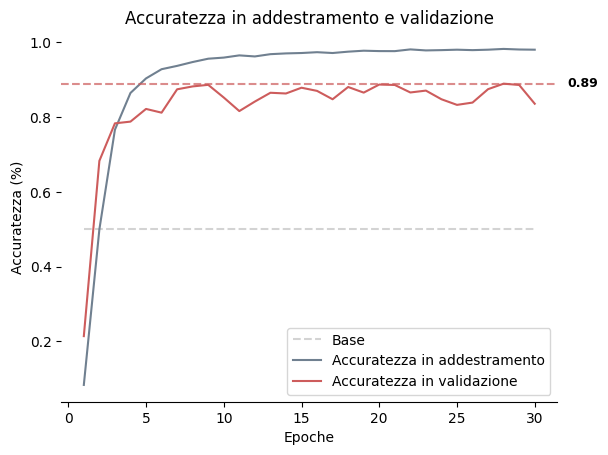

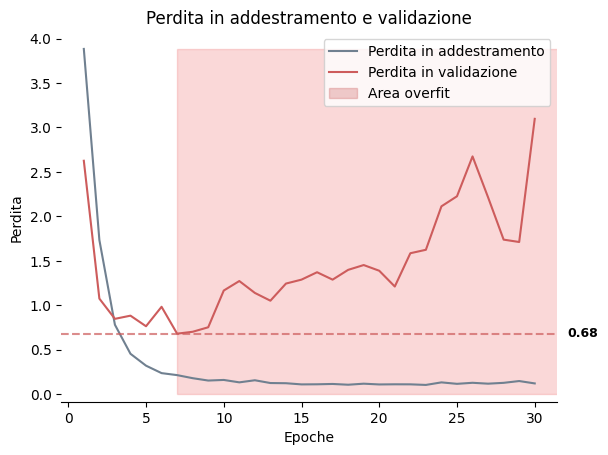

In [14]:
create_train_val_plot(basic_model_history.history)

Dal grafico si evince che il modello entra in overfitting poco dopo la quinta epoca, raggiungendo comunque ottimi risultati per quanto riguarda l'accuratezza del validation set, con **89** punti percentile.

La rete, inoltre, sembra essere lievemente migliore del modello addestrato sugli spettrogrammi, ma comparazioni più approffondite saranno affrontate su un notebook dedicato.

Verifichiamo l'accuratezza della migliore versione del modello di base.

In [8]:
best_basic_model = tf.keras.models.load_model("bestmodels/rmsprop/basic_model_fb.keras")
test_loss, test_acc = best_basic_model.evaluate(fb_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 2s 4ms/step - loss: 0.7222 - accuracy: 0.8625
Accuratezza: 0.862


In [7]:
evaluate_onnx_model("bestmodels/rmsprop/basic_model_fb.onnx", fb_test_ds)

Accuratezza: 0.862


Abbiamo ottenuto un'**accuratezza** del **86.2%**! Attualmente abbiamo riscontrato un miglioramento utilizzando i filter banks. Visualizziamo la distribuzione di accuratezza delle classi.

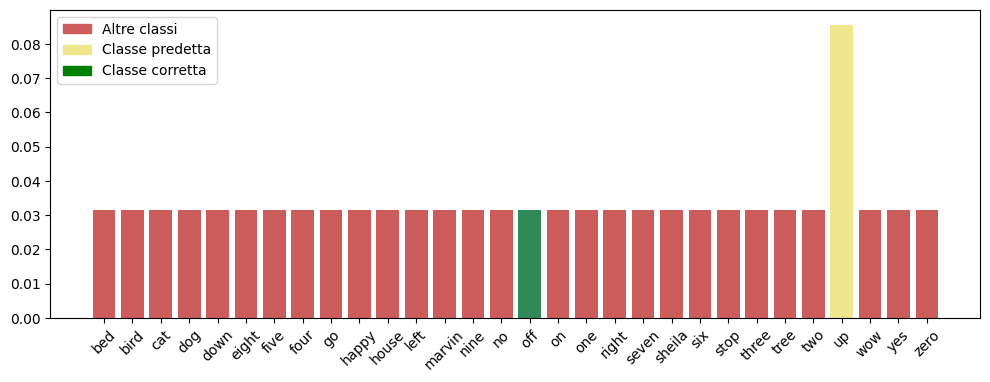

In [10]:
for audio, label in fb_test_ds: # prendiamo un audio a caso del test e creiamo la distribuzione
    create_distribution_plot(best_basic_model, audio, label)
    break

In questo specifico caso il modello ha **sbagliato totalmente** la classe predetta.

### Convolutivo base risoluzione dell'overfitting
In questa parte implementiamo il secondo modello presente nel notebook di riferimento, ovvero quello riguardante il paragrafo **risoluzione dell'overfitting**, dove viene aggiunto uno strato di dropout.

Come fatto prima, si procede con la creazione e l'addestramento del modello con l'ottimizzatore **rmsprop**. 

In [11]:
def get_improved_basic_model(input_shape):
    # Dichiariamo lo shape dell'input, ridimensioniamo le immagini, e normalizziamo
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Normalization()(inputs)

    # Blocco di apprendimento delle caratteristiche
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)

    # Blocco di classificazione
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [12]:
for audio, label in fb_train_ds:
    improved_basic_model = get_improved_basic_model(audio.shape[1:])
    break

improved_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [13]:
improved_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/rmsprop/improved_basic_model_fb.keras", save_best_only=True, monitor="val_loss")]
improved_history = improved_basic_model.fit(fb_train_ds, epochs=100, validation_data=fb_val_ds, callbacks=improved_basic_model_callbacks)

Epoch 1/100
243/243 [==============================] - 2s 6ms/step - loss: 3.5965 - accuracy: 0.0432 - val_loss: 3.3016 - val_accuracy: 0.0810
Epoch 2/100
243/243 [==============================] - 1s 6ms/step - loss: 2.5751 - accuracy: 0.2539 - val_loss: 1.6168 - val_accuracy: 0.5228
Epoch 3/100
243/243 [==============================] - 1s 6ms/step - loss: 1.2971 - accuracy: 0.6219 - val_loss: 1.1457 - val_accuracy: 0.6817
Epoch 4/100
243/243 [==============================] - 1s 6ms/step - loss: 0.7455 - accuracy: 0.7840 - val_loss: 0.8335 - val_accuracy: 0.7785
Epoch 5/100
243/243 [==============================] - 1s 5ms/step - loss: 0.4957 - accuracy: 0.8540 - val_loss: 0.7823 - val_accuracy: 0.8059
Epoch 6/100
243/243 [==============================] - 1s 5ms/step - loss: 0.3952 - accuracy: 0.8821 - val_loss: 0.4872 - val_accuracy: 0.8719
Epoch 7/100
243/243 [==============================] - 1s 5ms/step - loss: 0.3114 - accuracy: 0.9053 - val_loss: 0.5860 - val_accuracy: 0.8638

Seguiamo lo stesso ordine di prima per le operazione post-addestramento.

In [14]:
improved_history_df = convert_history_to_csv(improved_history)
improved_history_df.to_csv("model_histories/rmsprop/improved_history_fb.csv")

convert_model_to_onnx("bestmodels/rmsprop/improved_basic_model_fb.keras", (98, 40, 1))

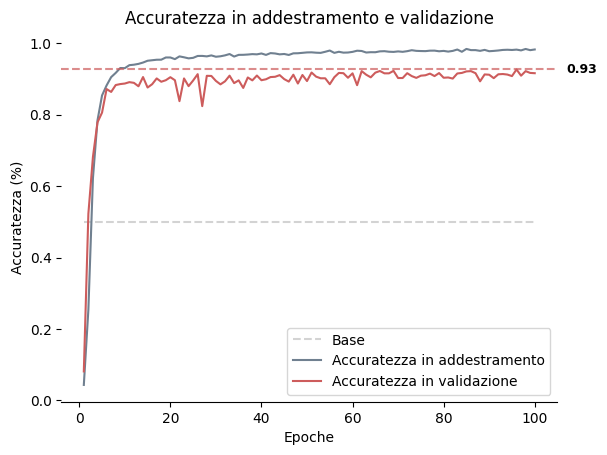

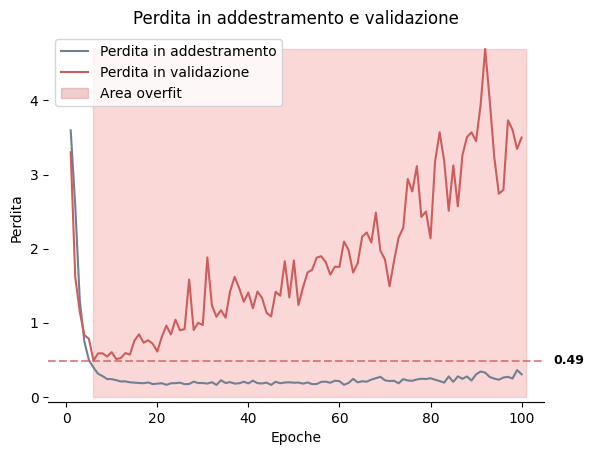

In [15]:
create_train_val_plot(improved_history.history)

I risultati sono decisamente positivi. Siamo riusciti a ritardare il sovradattamento, arrivando a livelli di perdita molto più bassi rispetto al precedente. Inoltre, l'accuratezza nel set di valutazione è salita del **4%**. 

In [16]:
improved_best_model = tf.keras.models.load_model("bestmodels/rmsprop/improved_basic_model_fb.keras")
test_loss, test_acc = improved_best_model.evaluate(fb_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 1s 5ms/step - loss: 0.5311 - accuracy: 0.8578
Accuratezza: 0.858


In [17]:
evaluate_onnx_model("bestmodels/rmsprop/improved_basic_model_fb.onnx", fb_test_ds)

Accuratezza: 0.858


L'aumento di prestazioni non vengono però rispecchiate nel test set, dove si giunge a un'accuratezza di **85.8%**, leggermente inferiore rispetto al precedente.


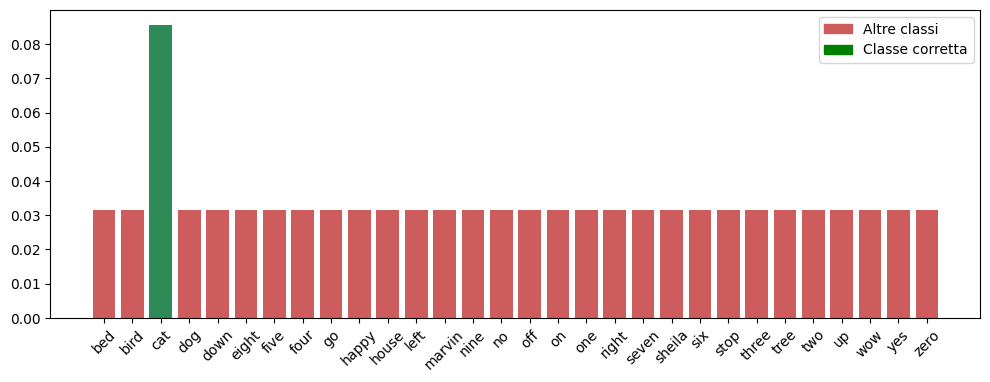

In [18]:
for audio, label in fb_test_ds:
    create_distribution_plot(improved_best_model, audio, label)
    break

### Fine tuning
In questa sezione effettuiamo il fine tuning nello stesso modo del notebook di riferimento.

In [6]:
def get_improved_basic_model_tuning(start_filters):
    # Dichiariamo lo shape dell'input, ridimensioniamo le immagini, e normalizziamo
    inputs = tf.keras.Input(shape=(98, 40, 1))
    x = tf.keras.layers.Normalization()(inputs)

    if not isinstance(start_filters, int):
        raise Exception("start_filters must be type integer")

    filters = [start_filters * (2 ** i) for i in range(4)]
    
    # Blocco di apprendimento delle caratteristiche
    x = tf.keras.layers.Conv2D(filters=filters[0], kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=filters[1], kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=filters[2], kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=filters[3], kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=filters[3], kernel_size=3, activation="relu", padding="same")(x)

    # Blocco di classificazione
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

def tuner(filters, learning_rates, max_epochs, train_dataset, validation_dataset):
    start_time = time.time()

    counter = 1
    
    if not isinstance(filters, list):
        raise Exception("parameter filters must be type list")

    if not isinstance(learning_rates, list):
        raise Exception("parameter learning_rates must be type list")

    callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]

    best_learning_rate = 0 
    best_filters = 0
    best_val_accuracy = 0

    best_model = 0
    
    for f in filters:
        for lr in learning_rates:
            print(f"\nAddestrando con filtri {[f * (2 ** i) for i in range(4)]} e tasso di apprendimento {lr}")
            
            model = get_improved_basic_model_tuning(start_filters=f)
            model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr), metrics=["accuracy"])
            model_history = model.fit(train_dataset, epochs=max_epochs, validation_data=validation_dataset, callbacks=callbacks)

            model_history_df = convert_history_to_csv(model_history)

            model_history_df[["filters"]] = f
            model_history_df[["learning_rate"]] = lr
            
            path = "model_tuning/histories/rmsprop/model_" + str(counter) + ".csv"
            model_history_df.to_csv(path)
            
            if best_val_accuracy < model_history_df.iloc[-1]["val_accuracy"]:
                best_val_accuracy = model_history_df.iloc[-1]["val_accuracy"]
                best_filters = f
                best_learning_rate = lr
                epoch = len(model_history_df)

            del model

            counter += 1

    total_time = time.time() - start_time
    minutes, seconds = divmod(total_time, 60)
    print(f"\nTempo totale trascorso: {int(minutes)} minuti e {int(seconds)} secondi")
    # print(f"Il miglior modello ha un filtro di partenza pari a {best_filters}, un learning rate pari a {best_learning_rate} con un'accuracy pari a {best_val_accuracy:.3f}")

    return best_filters, best_learning_rate

In [9]:
best_filter, best_learning_rate = tuner([16, 32, 64], [1e-3, 1e-4, 1e-5], 30, fb_train_ds, fb_val_ds)


Addestrando con filtri [16, 32, 64, 128] e tasso di apprendimento 0.001
Epoch 1/30
243/243 [==============================] - 6s 6ms/step - loss: 3.3033 - accuracy: 0.0823 - val_loss: 2.5604 - val_accuracy: 0.2485
Epoch 2/30
243/243 [==============================] - 1s 5ms/step - loss: 1.9749 - accuracy: 0.4111 - val_loss: 1.2945 - val_accuracy: 0.6262
Epoch 3/30
243/243 [==============================] - 1s 5ms/step - loss: 1.1052 - accuracy: 0.6720 - val_loss: 0.9096 - val_accuracy: 0.7292
Epoch 4/30
243/243 [==============================] - 1s 5ms/step - loss: 0.7069 - accuracy: 0.7867 - val_loss: 0.5758 - val_accuracy: 0.8337
Epoch 5/30
243/243 [==============================] - 1s 6ms/step - loss: 0.5186 - accuracy: 0.8465 - val_loss: 0.6037 - val_accuracy: 0.8333
Epoch 6/30
243/243 [==============================] - 1s 6ms/step - loss: 0.4050 - accuracy: 0.8722 - val_loss: 0.7101 - val_accuracy: 0.8268
Epoch 7/30
243/243 [==============================] - 1s 6ms/step - loss: 0

Il tempo necessario per la ricerca dei migliori iperparametri è stata di 5 minuti.

Visualizziamo l'accuratezza e la perdita di tutti i modelli che il tuner ha addestato.

In [5]:
def plot_models(path, reverse=False, show="accuracy", overfit=True):
    n_models = len(os.listdir(path))
    # creo il subplot a seconda di quanti modelli dispongo
    best_pair = None
    min_diff = float("inf")
    
    for idx_model in range(1, int(np.sqrt(n_models)) + 1):
        if n_models % idx_model == 0:
            diff = abs(idx_model - n_models // idx_model)

            if diff < min_diff:
                min_diff = diff
                best_pair = (idx_model, n_models // idx_model)

    if reverse:
        rows = best_pair[1]
        cols = best_pair[0]
    else:
        rows = best_pair[0]
        cols = best_pair[1]
    
    fig, axes = plt.subplots(rows, cols, figsize=(14, 10))
    
    for index, model in enumerate(os.listdir(path)):
        row = index // cols
        col = index % cols
    
        ax = axes[row][col]
        
        newpath = path + "/" + model
        df = pd.read_csv(newpath)

        value1 = df[show].values
        value2 = df["val_" + show].values
        
        ax.plot(range(1, len(value1) + 1), value1, color="slategray", label="Addestramento")
        ax.plot(range(1, len(value2) + 1), value2, color="indianred", label="Validazione")

        if (row in range(rows)) and col == 0:
            ax.set_ylabel("Accuratezza (%)" if show == "accuracy" else "Perdita", fontweight="semibold", fontsize=10)

        if (col in range(cols)) and row == 2:
            ax.set_xlabel("Epoche", fontweight="semibold", fontsize=10)

        ax.set_title("Filtro " + str(df["filters"][0]) + " & lr " + str(df["learning_rate"][0]), fontsize=12)
            
        ax.set_ylim(0)
        ax.set_xlim(0)

        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        ax.grid(True, color="gainsboro", alpha=0.3, linestyle="--")

        handles, _ = ax.get_legend_handles_labels()
        
        if overfit and show == "loss":
            # area overfit
            
            rect = mpatches.Rectangle((np.argmin(value2) + 1, 0), width=len(value1) - np.argmin(value2), height=max(max(value1), max(value2)), color='lightcoral', alpha=0.3)
            ax.add_patch(rect)
            # patch overfit per legenda
            overfit = mpatches.Patch(color='lightcoral', alpha=0.3, label='Area overfit')
           
            handles.append(overfit)

        ax.legend(handles=handles)

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()

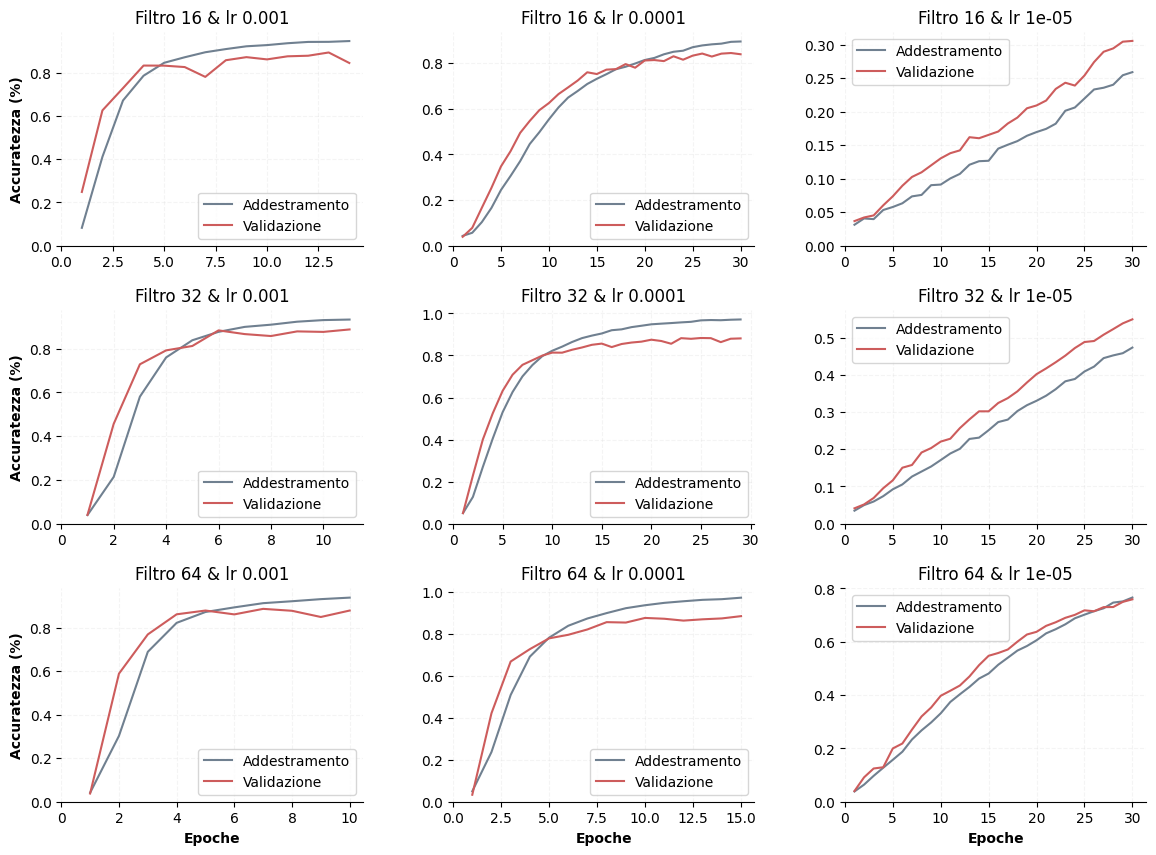

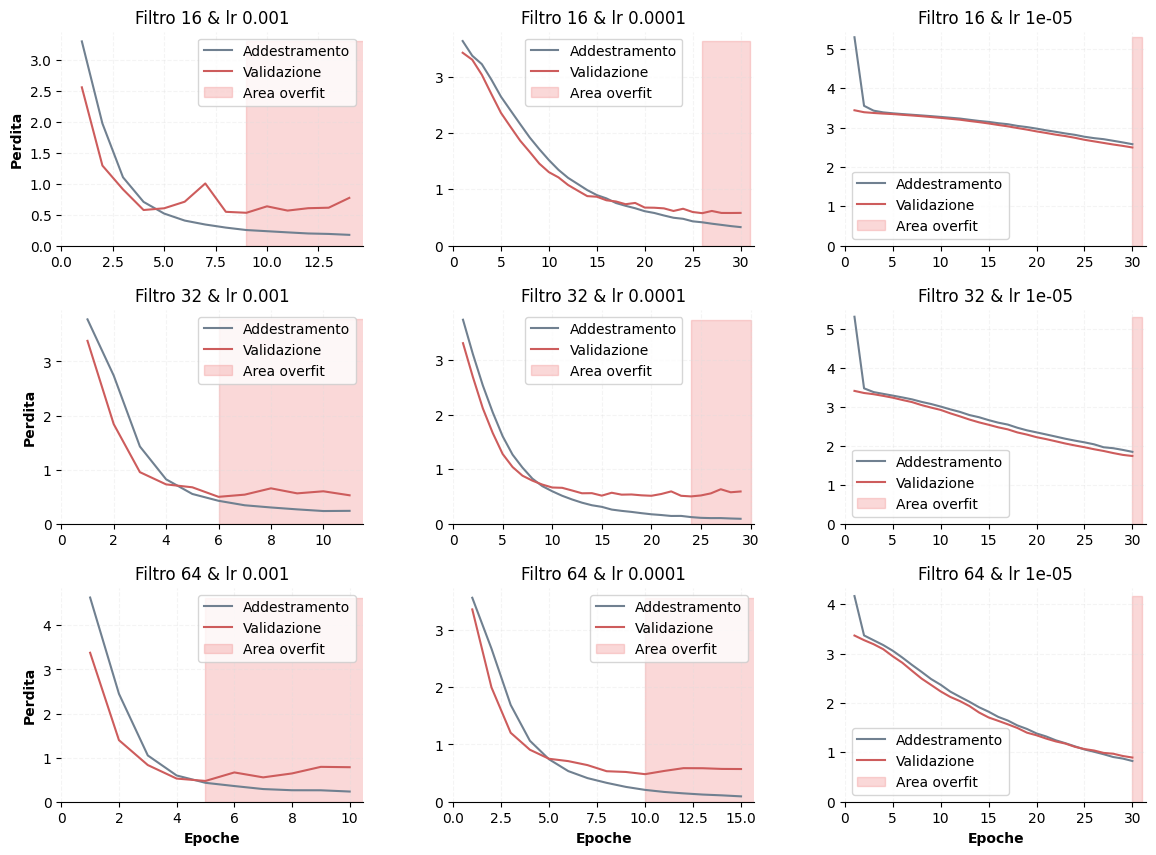

In [13]:
plot_models(path="model_tuning/histories/rmsprop", show="accuracy")
plot_models(path="model_tuning/histories/rmsprop", show="loss")

Dai grafici emerge che la combinazione più performante è composta da **32 filtri di partenza** e un **tasso di apprendimento di 0.0001**, poiché ritarda maggiormente l'overfitting. Altre combinazioni, come **64 filtri di partenza** e un **tasso di apprendimento di 0.0001**, mostrano buone prestazioni ma anche un inizio di overfitting, evidenziato dallo distaccamento tra la perdita di addestramento e quella di validazione.

Procediamo quindi con l'addestramento del modello con **32 filtri di partenza** e un **tasso di apprendimento di 0.0001**. Come di consueto, salviamo i risultati in un file `keras` e la cronologia (history) in un file `csv`. Infine, convertiamo il file in formato `onnx`.

# DA RIFARE 

In [19]:
for audio, label in fb_train_ds:
    tuned_improved_basic_model = get_improved_basic_model(audio.shape[1:])
    break

tuned_improved_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5), metrics=["accuracy"])

In [20]:
tuned_improved_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/rmsprop/tuned_improved_basic_model_fb.keras", save_best_only=True, monitor="val_loss")]
tuned_improved_history = tuned_improved_basic_model.fit(fb_train_ds, epochs=100, validation_data=fb_val_ds, callbacks=tuned_improved_basic_model_callbacks)

Epoch 1/100
243/243 [==============================] - 2s 6ms/step - loss: 5.1715 - accuracy: 0.0378 - val_loss: 3.3684 - val_accuracy: 0.0486
Epoch 2/100
243/243 [==============================] - 1s 5ms/step - loss: 3.4523 - accuracy: 0.0481 - val_loss: 3.3232 - val_accuracy: 0.0745
Epoch 3/100
243/243 [==============================] - 1s 5ms/step - loss: 3.3576 - accuracy: 0.0616 - val_loss: 3.2900 - val_accuracy: 0.0980
Epoch 4/100
243/243 [==============================] - 1s 5ms/step - loss: 3.3056 - accuracy: 0.0826 - val_loss: 3.2444 - val_accuracy: 0.1238
Epoch 5/100
243/243 [==============================] - 1s 5ms/step - loss: 3.2642 - accuracy: 0.0963 - val_loss: 3.1910 - val_accuracy: 0.1524
Epoch 6/100
243/243 [==============================] - 1s 5ms/step - loss: 3.2123 - accuracy: 0.1059 - val_loss: 3.1449 - val_accuracy: 0.1636
Epoch 7/100
243/243 [==============================] - 1s 5ms/step - loss: 3.1641 - accuracy: 0.1309 - val_loss: 3.0849 - val_accuracy: 0.1771

In [21]:
tuned_improved_history_df = convert_history_to_csv(tuned_improved_history)
tuned_improved_history_df.to_csv("model_histories/rmsprop/tuned_improved_history_fb.csv")

convert_model_to_onnx("bestmodels/rmsprop/tuned_improved_basic_model_fb.keras", (98, 40, 1))

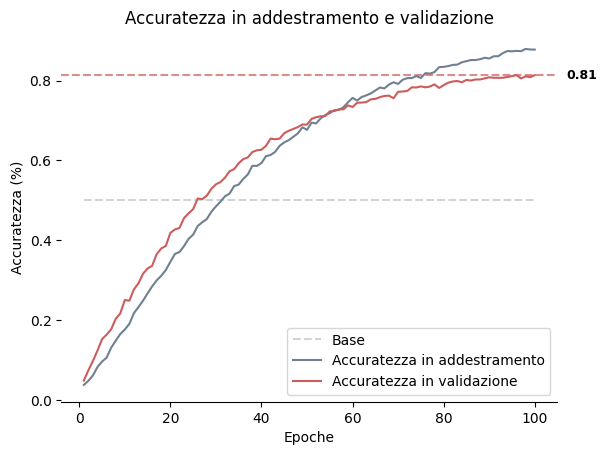

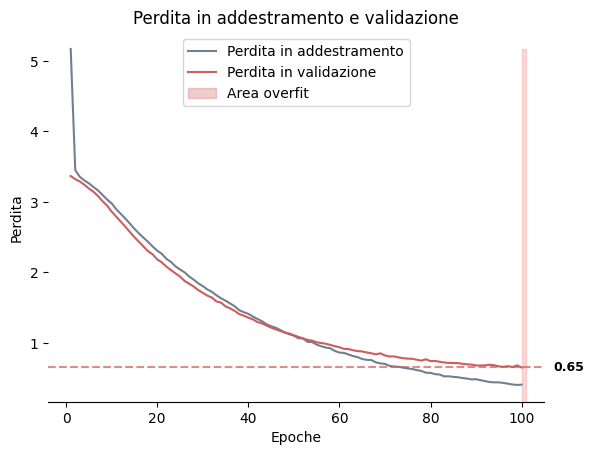

In [22]:
create_train_val_plot(tuned_improved_history.history)

In questo caso il modello non è ancora andato in overfitting, perciò magari avremmo potuto addestrarlo per qualche epoca in più. L'accuratezza in addestramento e validazione sono basse rispetto ai modelli precedenti, dovuto molto probabilmente dalla quantità limitata di epoche.

In [23]:
tuned_improved_best_model = tf.keras.models.load_model("bestmodels/rmsprop/tuned_improved_basic_model_fb.keras")
test_loss, test_acc = tuned_improved_best_model.evaluate(fb_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 0.8074
Accuratezza: 0.807


In [24]:
evaluate_onnx_model("bestmodels/rmsprop/tuned_improved_basic_model_fb.onnx", fb_test_ds)

Accuratezza: 0.807


Come ci aspettavamo dall'andamento dell'accuratezza, il modello ha registrato delle prestazioni inferiori rispetto a prima ma senza andare in overfitting. L'accuratezza corrisponde a **80.7%**.

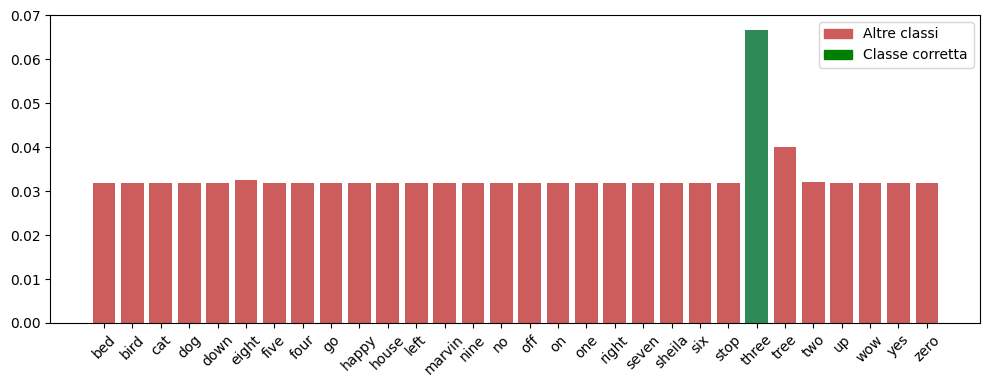

In [25]:
for audio, label in fb_test_ds:
    create_distribution_plot(tuned_improved_best_model, audio, label)
    break

Un fattore molto positivo riguarda la distinzione corretta di parole molto simili, come in questo caso **three** e **tree**.

### Miglioramenti all'architettura del modello convolutivo
In questa ultima fase riguardante i filterbanks andremo ad addestrare il modello corrispondente alla sezione **miglioramenti all'architettura del modello** del notebook di riferimento.

Si procede con la creazione dell'architettura composta da blocchi residuali, il suo addestramento e la dimostrazione grafica dell'andamento.

In [26]:
def residual_block(x, filters, pooling=False):
    residual = x

    x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    if pooling:
      x = tf.keras.layers.MaxPooling2D(pool_size=2, padding="same")(x)
      residual = tf.keras.layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
      residual = tf.keras.layers.Conv2D(filters, 1)(residual)

    x = tf.keras.layers.add([x, residual])
    return x

def bp_basic_model(input_shape):
    # input e pre processamento
    inputs = tf.keras.Input(shape=input_shape)
    
    x = residual_block(inputs, 32, pooling=True)
    x = residual_block(x, 64, pooling=True)
    x = residual_block(x, 128, pooling=True)
    x = residual_block(x, 256, pooling=True)
    x = residual_block(x, 256, pooling=False)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Livelli per la classificazione
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [27]:
for audio, label in fb_train_ds:
    bp_basic_model = bp_basic_model(audio.shape[1:])
    break

bp_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

bp_basic_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 98, 40, 1)]  0           []                               
                                                                                                  
 separable_conv2d (SeparableCon  (None, 98, 40, 32)  41          ['input_3[0][0]']                
 v2D)                                                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 98, 40, 32)  128         ['separable_conv2d[0][0]']       
 alization)                                                                                       
                                                                                            

Il numero di parametri in questo caso non è cambiato rispetto al notebook di riferimento.

In [28]:
bp_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/rmsprop/bp_basic_model_fb.keras", save_best_only=True, monitor="val_loss")]
bp_model_history = bp_basic_model.fit(fb_train_ds, epochs=100, validation_data=fb_val_ds, callbacks=bp_basic_model_callbacks)

Epoch 1/100
243/243 [==============================] - 4s 11ms/step - loss: 5.7763 - accuracy: 0.0530 - val_loss: 3.8609 - val_accuracy: 0.0355
Epoch 2/100
243/243 [==============================] - 2s 10ms/step - loss: 2.9183 - accuracy: 0.1841 - val_loss: 3.2534 - val_accuracy: 0.1424
Epoch 3/100
243/243 [==============================] - 2s 10ms/step - loss: 2.0791 - accuracy: 0.3932 - val_loss: 2.2703 - val_accuracy: 0.3584
Epoch 4/100
243/243 [==============================] - 2s 10ms/step - loss: 1.4526 - accuracy: 0.5807 - val_loss: 2.6780 - val_accuracy: 0.3823
Epoch 5/100
243/243 [==============================] - 2s 9ms/step - loss: 1.0838 - accuracy: 0.6872 - val_loss: 3.7444 - val_accuracy: 0.2253
Epoch 6/100
243/243 [==============================] - 2s 9ms/step - loss: 0.8619 - accuracy: 0.7575 - val_loss: 1.8909 - val_accuracy: 0.4992
Epoch 7/100
243/243 [==============================] - 2s 9ms/step - loss: 0.7006 - accuracy: 0.7996 - val_loss: 1.1722 - val_accuracy: 0.

In [29]:
bp_model_history_df = convert_history_to_csv(bp_model_history)
bp_model_history_df.to_csv("model_histories/rmsprop/bp_model_history_fb.csv")

convert_model_to_onnx("bestmodels/rmsprop/bp_basic_model_fb.keras", (98, 40, 1))

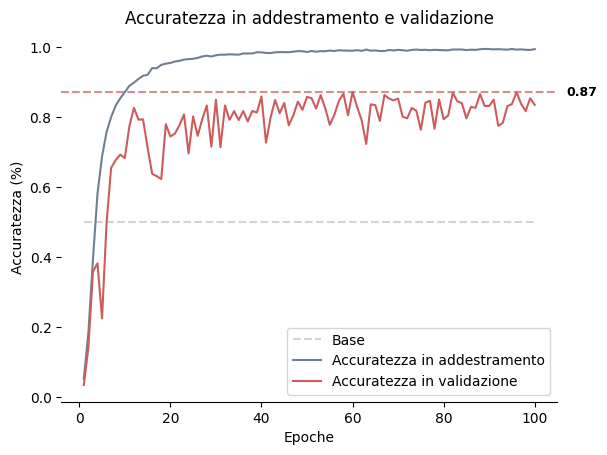

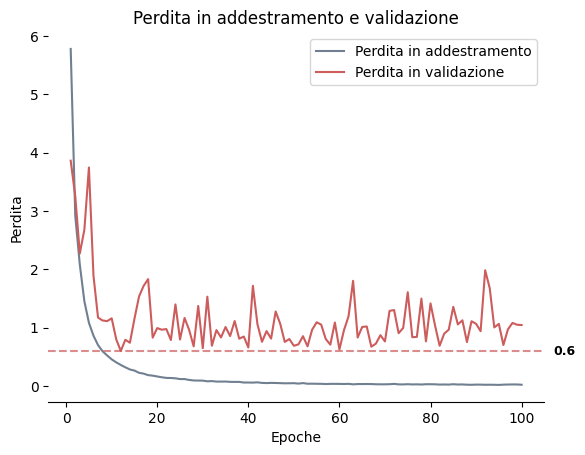

In [30]:
create_train_val_plot(bp_model_history.history, overfit=False)

In questo caso il modello ha perfomato peggio rispetto al corrispettivo. Il valore minimo di loss è maggiore, mentre il valore massimo di accuratezza è inferiore.

In [31]:
best_bp_basic_model = tf.keras.models.load_model("bestmodels/rmsprop/bp_basic_model_fb.keras")
test_loss, test_acc = best_bp_basic_model.evaluate(fb_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.8063
Accuratezza: 0.806


In [32]:
evaluate_onnx_model("bestmodels/rmsprop/bp_basic_model_fb.onnx", fb_test_ds)

Accuratezza: 0.806


Essendo la perdita minore presente circa all'epoca 15, il modello salvato corrisponde a quello. Perciò di conseguenza anche l'accuratezza risulta essere minore.

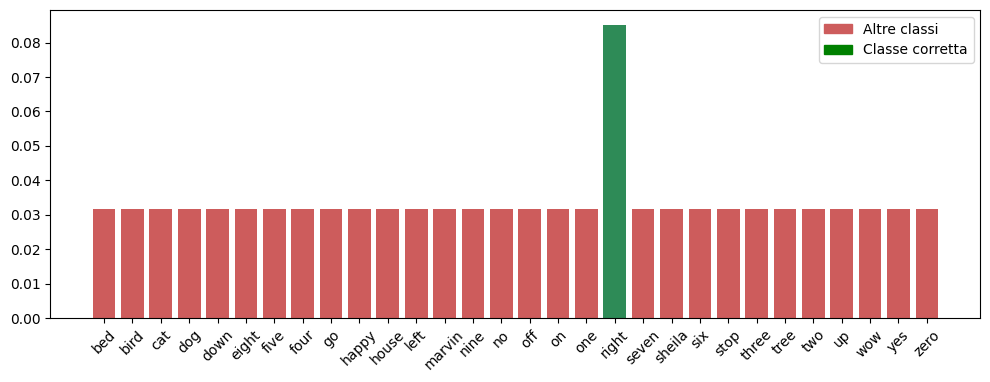

In [33]:
for audio, label in fb_test_ds:
    create_distribution_plot(best_bp_basic_model, audio, label)
    break

## Addestramento modello convolutivo base (mfcc)
L'ultimo argomento che trattiamo nel notebook riguarda l'uso degli mfcc come dati in input ai modelli. 

Procediamo nello stesso modo fatto sopra, quindi trasformiamo i dati con la nostra classe e otteniamo i set di train, validation e test.

In [6]:
mfcc_train_ds = DatasetConverter(train_ds)
mfcc_train_ds = mfcc_train_ds.convert('mfcc')

mfcc_validation_ds = DatasetConverter(validation_ds)
mfcc_validation_ds = mfcc_validation_ds.convert('mfcc')

mfcc_val_ds = mfcc_validation_ds.take(mfcc_validation_ds.cardinality() // 2)
mfcc_test_ds = mfcc_validation_ds.skip(mfcc_validation_ds.cardinality() // 2)

Considerata la grandezza ridotta della matrice degli mfcc, dobbiamo apportare una leggera modifica al modello convolutivo di base, applicando il **padding** nel livello `MaxPooling2D_4`.

In [35]:
def get_basic_model(input_shape):
    # Dichiariamo lo shape dell'input, ridimensioniamo le immagini, e normalizziamo
    inputs = tf.keras.Input(shape=input_shape, name="inputs")
    x = tf.keras.layers.Normalization(name="normalizzazione")(inputs)

    # Blocco di apprendimento delle caratteristiche
    conv2D_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same", name="conv2D_1")(x)
    MaxPooling2D_1 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPooling2D_1")(conv2D_1)
    conv2D_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same", name="conv2D_2")(MaxPooling2D_1)
    MaxPooling2D_2 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPooling2D_2")(conv2D_2)
    conv2D_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same", name="conv2D_3")(MaxPooling2D_2)
    MaxPooling2D_3 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPooling2D_3")(conv2D_3)
    conv2D_4 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same", name="conv2D_4")(MaxPooling2D_3)
    MaxPooling2D_4 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPooling2D_4", padding="same")(conv2D_4)
    conv2D_5 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same", name="conv2D_5")(MaxPooling2D_4)

    # Blocco di classificazione
    Flatten = tf.keras.layers.Flatten(name="Flatten")(conv2D_5)
    outputs = tf.keras.layers.Dense(30, activation="softmax", name="dense_output")(Flatten)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [36]:
for audio, label in mfcc_train_ds:
    basic_model = get_basic_model(audio.shape[1:])
    break
    
basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

basic_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 98, 12, 1)]       0         
                                                                 
 normalizzazione (Normalizat  (None, 98, 12, 1)        3         
 ion)                                                            
                                                                 
 conv2D_1 (Conv2D)           (None, 98, 12, 32)        320       
                                                                 
 MaxPooling2D_1 (MaxPooling2  (None, 49, 6, 32)        0         
 D)                                                              
                                                                 
 conv2D_2 (Conv2D)           (None, 49, 6, 64)         18496     
                                                                 
 MaxPooling2D_2 (MaxPooling2  (None, 24, 3, 64)        0   

Anche in questo caso notiamo una **diminuzione dei parametri di circa 50.000**, dovuto alla differenza di grandezza della matrice.

In [37]:
basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/rmsprop/basic_model_mfcc.keras", save_best_only=True, monitor="val_loss")]
basic_model_history = basic_model.fit(mfcc_train_ds, epochs=30, batch_size=32, validation_data=mfcc_val_ds, callbacks=basic_model_callbacks)

Epoch 1/30
243/243 [==============================] - 2s 6ms/step - loss: 3.0976 - accuracy: 0.2307 - val_loss: 1.8341 - val_accuracy: 0.4749
Epoch 2/30
243/243 [==============================] - 1s 5ms/step - loss: 1.3164 - accuracy: 0.6166 - val_loss: 1.1820 - val_accuracy: 0.6833
Epoch 3/30
243/243 [==============================] - 1s 6ms/step - loss: 0.7657 - accuracy: 0.7714 - val_loss: 1.0194 - val_accuracy: 0.7454
Epoch 4/30
243/243 [==============================] - 1s 6ms/step - loss: 0.5076 - accuracy: 0.8487 - val_loss: 0.9253 - val_accuracy: 0.7905
Epoch 5/30
243/243 [==============================] - 1s 5ms/step - loss: 0.3870 - accuracy: 0.8857 - val_loss: 2.3024 - val_accuracy: 0.6543
Epoch 6/30
243/243 [==============================] - 1s 4ms/step - loss: 0.3116 - accuracy: 0.9081 - val_loss: 1.3706 - val_accuracy: 0.7623
Epoch 7/30
243/243 [==============================] - 1s 4ms/step - loss: 0.2939 - accuracy: 0.9184 - val_loss: 1.1739 - val_accuracy: 0.7909
Epoch 

Salviamo i dati della history del modello in un file **csv** e convertiamo il miglior modello nell'estensione **.onnx**.

In [38]:
basic_model_history_df = convert_history_to_csv(basic_model_history)
basic_model_history_df.to_csv("model_histories/rmsprop/basic_model_history_mfcc.csv")

convert_model_to_onnx("bestmodels/rmsprop/basic_model_mfcc.keras", (98, 12, 1))

Visualizziamo l'andamento dell'accurateza e della perdita durante l'addestramento.

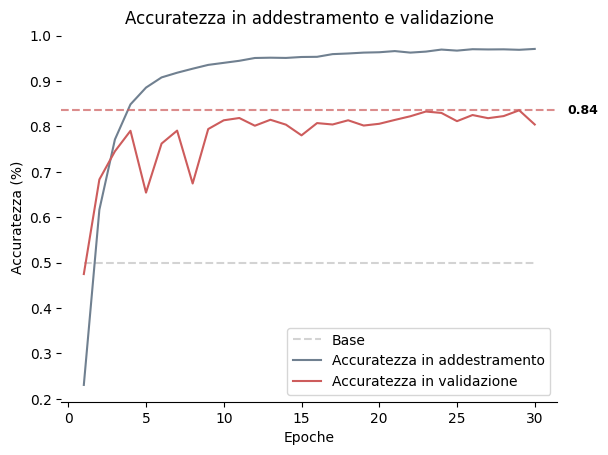

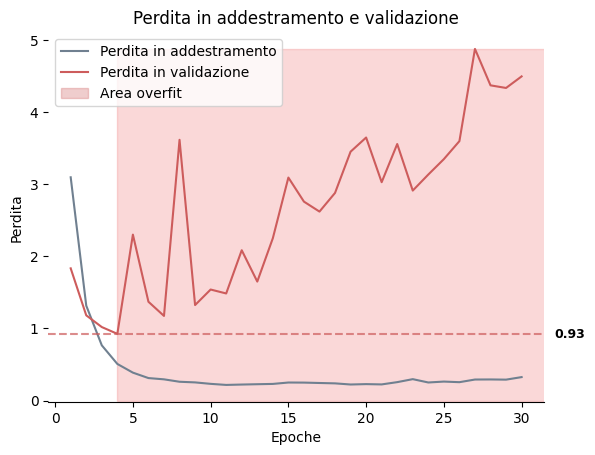

In [39]:
create_train_val_plot(basic_model_history.history)

Il modello di base addestrato sugli mfcc non ha performato bene quanto quello con i filterbanks. Raggiunge molto presto un adattamento ai dati e si nota un degradamento dell'accuratezza di **7 punti percentile**, con un aumento importante nel valore della perdita.

Verifichiamo l'accuratezza della migliore versione del modello di base.

In [40]:
best_basic_model = tf.keras.models.load_model("bestmodels/rmsprop/basic_model_mfcc.keras")
test_loss, test_acc = best_basic_model.evaluate(mfcc_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 0s 5ms/step - loss: 0.9633 - accuracy: 0.7648
Accuratezza: 0.765


In [41]:
evaluate_onnx_model("bestmodels/rmsprop/basic_model_mfcc.onnx", mfcc_test_ds)

Accuratezza: 0.765


Abbiamo ottenuto un'**accuratezza** del **76.5%**. Vediamo come si evolve con i prossimi modelli.

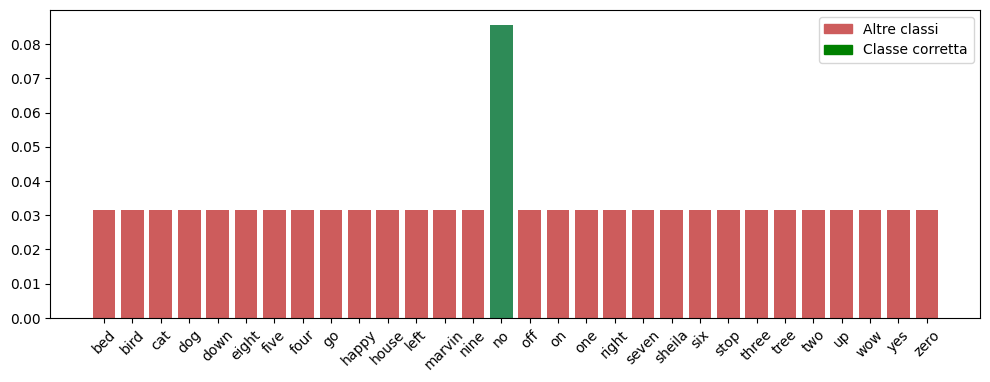

In [43]:
for audio, label in mfcc_test_ds: # prendiamo un audio a caso del test e creiamo la distribuzione
    create_distribution_plot(best_basic_model, audio, label)
    break

### Convolutivo base risoluzione dell'overfitting
In questa parte andremo a utilizzare il secondo modello presente nel notebook di riferimento, perciò il modello riguardante il paragrafo **risoluzione dell'overfitting**. Anche in questo caso, a causa della grandezza ridotta della matrice, è necessario applicare la stessa modifica allo stesso livello di MaxPooling.

In [46]:
def get_improved_basic_model(input_shape):
    # Dichiariamo lo shape dell'input, ridimensioniamo le immagini, e normalizziamo
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Normalization()(inputs)

    # Blocco di apprendimento delle caratteristiche
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)

    # Blocco di classificazione
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [47]:
for audio, label in mfcc_train_ds:
    improved_basic_model = get_improved_basic_model(audio.shape[1:])
    break

improved_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [48]:
improved_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/rmsprop/improved_basic_model_mfcc.keras", save_best_only=True, monitor="val_loss")]
improved_history = improved_basic_model.fit(mfcc_train_ds, epochs=100, validation_data=mfcc_val_ds, callbacks=improved_basic_model_callbacks)

Epoch 1/100
243/243 [==============================] - 2s 5ms/step - loss: 3.1169 - accuracy: 0.1700 - val_loss: 2.1803 - val_accuracy: 0.3723
Epoch 2/100
243/243 [==============================] - 1s 4ms/step - loss: 1.6812 - accuracy: 0.5111 - val_loss: 1.0962 - val_accuracy: 0.6817
Epoch 3/100
243/243 [==============================] - 1s 4ms/step - loss: 1.0549 - accuracy: 0.6851 - val_loss: 0.9353 - val_accuracy: 0.7365
Epoch 4/100
243/243 [==============================] - 1s 4ms/step - loss: 0.7933 - accuracy: 0.7727 - val_loss: 1.0016 - val_accuracy: 0.7500
Epoch 5/100
243/243 [==============================] - 1s 6ms/step - loss: 0.6330 - accuracy: 0.8095 - val_loss: 0.7824 - val_accuracy: 0.7809
Epoch 6/100
243/243 [==============================] - 1s 5ms/step - loss: 0.5135 - accuracy: 0.8451 - val_loss: 0.7870 - val_accuracy: 0.7948
Epoch 7/100
243/243 [==============================] - 1s 5ms/step - loss: 0.4397 - accuracy: 0.8660 - val_loss: 0.9528 - val_accuracy: 0.8117

In [49]:
improved_history_df = convert_history_to_csv(improved_history)
improved_history_df.to_csv("model_histories/rmsprop/improved_history_mfcc.csv")

convert_model_to_onnx("bestmodels/rmsprop/improved_basic_model_mfcc.keras", (98, 12, 1))

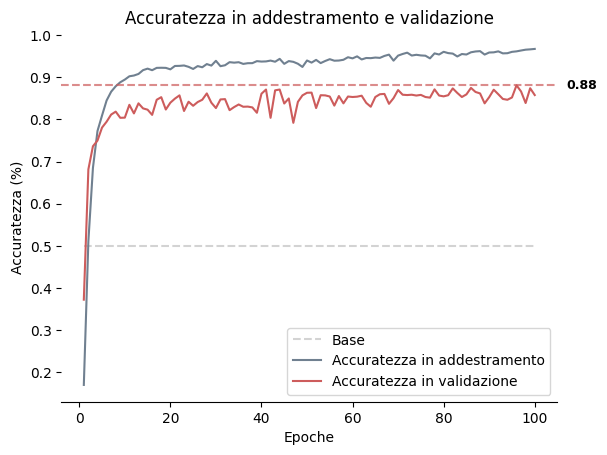

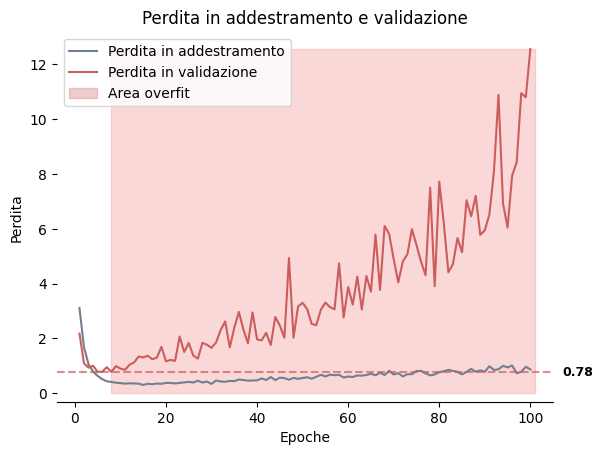

In [50]:
create_train_val_plot(improved_history.history)

In questo caso abbiamo ottenuto dei miglioramenti nella gestione dell'overfitting, un aumento del valore massimo di accuratezza e un livello di perdita minimo inferiore.

In [51]:
improved_best_model = tf.keras.models.load_model("bestmodels/rmsprop/improved_basic_model_mfcc.keras")
test_loss, test_acc = improved_best_model.evaluate(mfcc_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 0s 3ms/step - loss: 0.8236 - accuracy: 0.8179
Accuratezza: 0.818


In [52]:
evaluate_onnx_model("bestmodels/rmsprop/improved_basic_model_mfcc.onnx", mfcc_test_ds)

Accuratezza: 0.818


Questi cambiamenti hanno portato ad ottenere un'accuratezza pari a **81.8%** nei dati di test! Un significativo aumento confrontando i precedenti. 

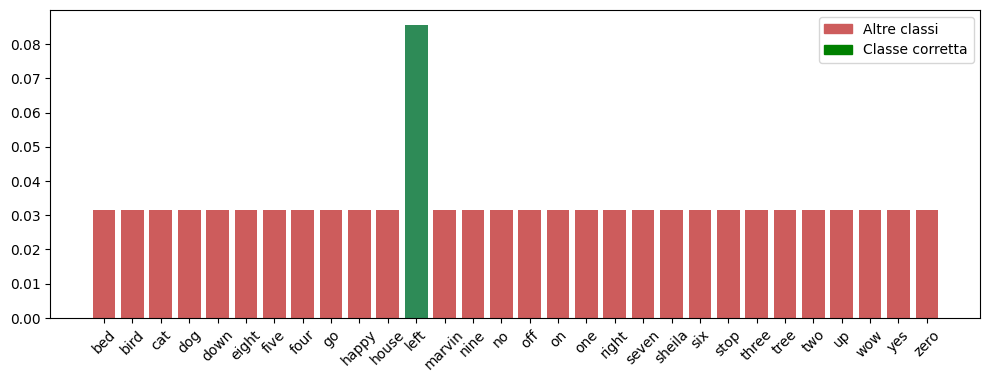

In [53]:
for audio, label in mfcc_test_ds:
    create_distribution_plot(improved_best_model, audio, label)
    break

### Fine tuning
In questa sezione effettuiamo il fine tuning anche per il dataset mfcc. Ovviamente anche in questo caso adattiamo il modello ai mfcc.

In [7]:
def get_improved_basic_model_tuning(start_filters):
    # Dichiariamo lo shape dell'input, ridimensioniamo le immagini, e normalizziamo
    inputs = tf.keras.Input(shape=(98, 12, 1))
    x = tf.keras.layers.Normalization()(inputs)

    if not isinstance(start_filters, int):
        raise Exception("start_filters must be type integer")

    filters = [start_filters * (2 ** i) for i in range(4)]
    
    # Blocco di apprendimento delle caratteristiche
    x = tf.keras.layers.Conv2D(filters=filters[0], kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=filters[1], kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=filters[2], kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=filters[3], kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding="same")(x)
    x = tf.keras.layers.Conv2D(filters=filters[3], kernel_size=3, activation="relu", padding="same")(x)

    # Blocco di classificazione
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

def tuner(filters, learning_rates, max_epochs, train_dataset, validation_dataset):
    start_time = time.time()

    counter = 1
    
    if not isinstance(filters, list):
        raise Exception("parameter filters must be type list")

    if not isinstance(learning_rates, list):
        raise Exception("parameter learning_rates must be type list")

    callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]

    best_learning_rate = 0 
    best_filters = 0
    best_val_accuracy = 0

    best_model = 0
    
    for f in filters:
        for lr in learning_rates:
            print(f"\nAddestrando con filtri {[f * (2 ** i) for i in range(4)]} e tasso di apprendimento {lr}")
            
            model = get_improved_basic_model_tuning(start_filters=f)
            model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr), metrics=["accuracy"])
            model_history = model.fit(train_dataset, epochs=max_epochs, validation_data=validation_dataset, callbacks=callbacks)

            model_history_df = convert_history_to_csv(model_history)

            model_history_df[["filters"]] = f
            model_history_df[["learning_rate"]] = lr
            
            path = "model_tuning/histories/rmsprop/model_" + str(counter) + ".csv"
            model_history_df.to_csv(path)
            
            if best_val_accuracy < model_history_df.iloc[-1]["val_accuracy"]:
                best_val_accuracy = model_history_df.iloc[-1]["val_accuracy"]
                best_filters = f
                best_learning_rate = lr
                epoch = len(model_history_df)

            del model

            counter += 1

    total_time = time.time() - start_time
    minutes, seconds = divmod(total_time, 60)
    print(f"\nTempo totale trascorso: {int(minutes)} minuti e {int(seconds)} secondi")
    # print(f"Il miglior modello ha un filtro di partenza pari a {best_filters}, un learning rate pari a {best_learning_rate} con un'accuracy pari a {best_val_accuracy:.3f}")

    return best_filters, best_learning_rate

In [8]:
best_filter, best_learning_rate = tuner([16, 32, 64], [1e-3, 1e-4, 1e-5], 30, mfcc_train_ds, mfcc_val_ds)


Addestrando con filtri [16, 32, 64, 128] e tasso di apprendimento 0.001
Epoch 1/30
243/243 [==============================] - 5s 7ms/step - loss: 3.1934 - accuracy: 0.1156 - val_loss: 2.5065 - val_accuracy: 0.2566
Epoch 2/30
243/243 [==============================] - 1s 6ms/step - loss: 2.2004 - accuracy: 0.3527 - val_loss: 1.6617 - val_accuracy: 0.5208
Epoch 3/30
243/243 [==============================] - 2s 6ms/step - loss: 1.5314 - accuracy: 0.5454 - val_loss: 1.2900 - val_accuracy: 0.6219
Epoch 4/30
243/243 [==============================] - 1s 6ms/step - loss: 1.1582 - accuracy: 0.6573 - val_loss: 1.0257 - val_accuracy: 0.6968
Epoch 5/30
243/243 [==============================] - 1s 5ms/step - loss: 0.9576 - accuracy: 0.7193 - val_loss: 0.9089 - val_accuracy: 0.7326
Epoch 6/30
243/243 [==============================] - 1s 4ms/step - loss: 0.8138 - accuracy: 0.7545 - val_loss: 0.9404 - val_accuracy: 0.7396
Epoch 7/30
243/243 [==============================] - 1s 4ms/step - loss: 0

Il tempo necessario per la ricerca dei migliori iperparametri è stata di 4 minuti.

Visualizziamo l'accuratezza e la perdita di tutti i modelli che il tuner ha addestato.

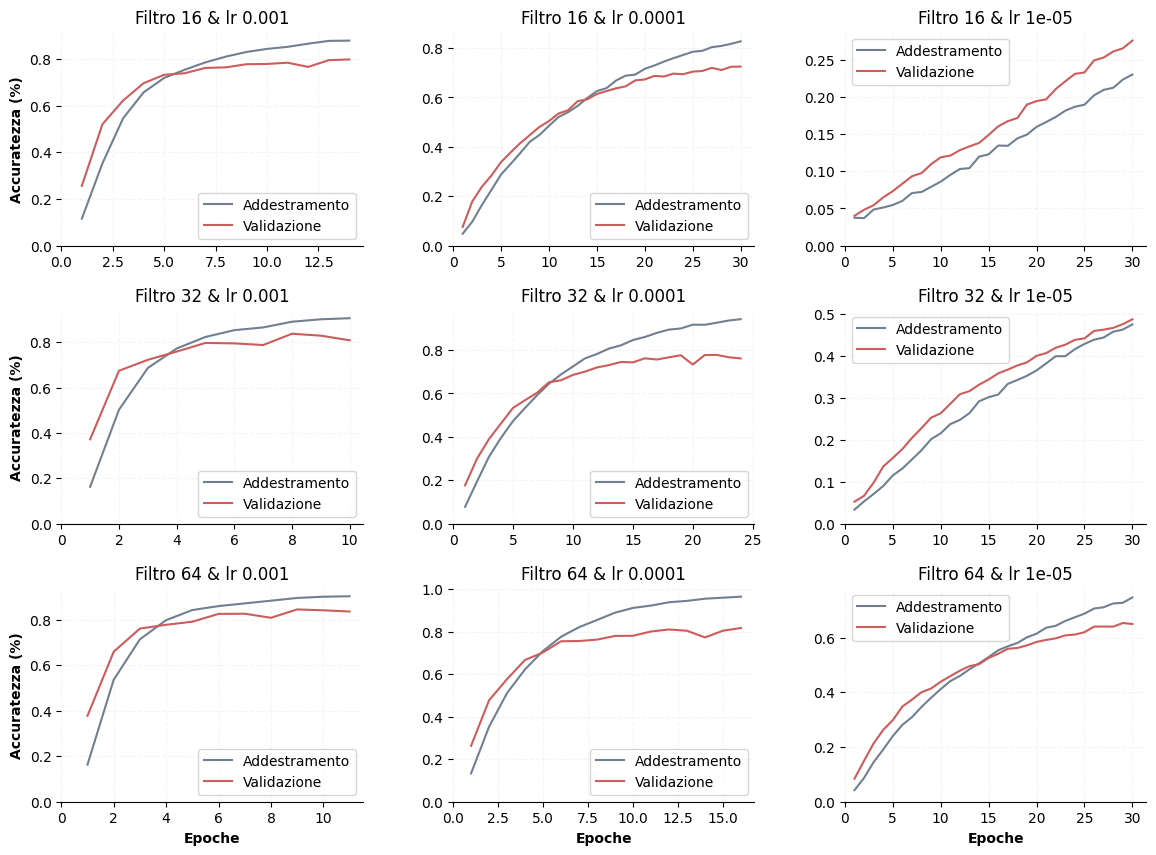

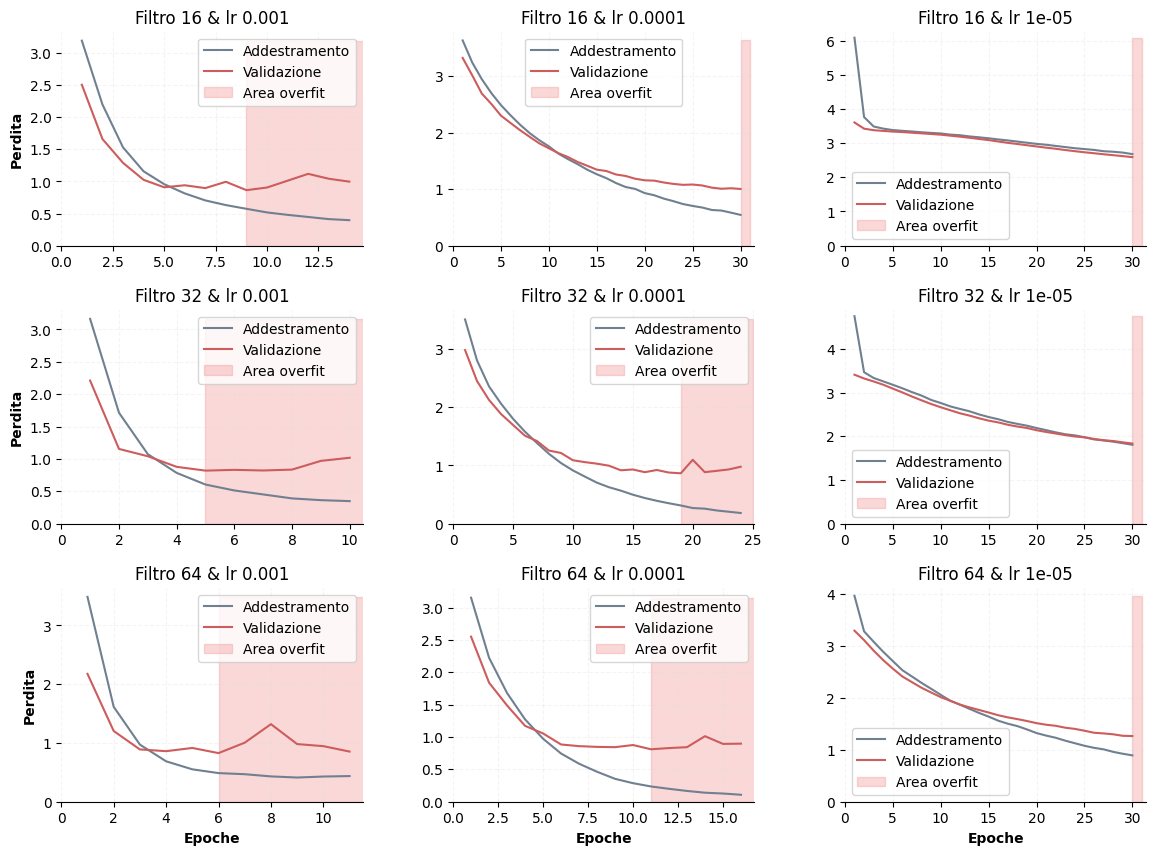

In [9]:
plot_models(path="model_tuning/histories/rmsprop", show="accuracy")
plot_models(path="model_tuning/histories/rmsprop", show="loss")

Dai grafici emerge che la combinazione più performante è composta da **32 filtri di partenza** e un **tasso di apprendimento di 0.0001**, poiché ritarda maggiormente l'overfitting. Altre combinazioni, come **64 filtri di partenza** e un **tasso di apprendimento di 0.0001**, mostrano buone prestazioni ma anche un inizio di overfitting, evidenziato dallo distaccamento tra la perdita di addestramento e quella di validazione.

Procediamo quindi con l'addestramento del modello con **32 filtri di partenza** e un **tasso di apprendimento di 0.0001**. Come di consueto, salviamo i risultati in un file `keras` e la cronologia (history) in un file `csv`. Infine, convertiamo il file in formato `onnx`.

# DA RIFARE

In [54]:
for audio, label in mfcc_train_ds:
    tuned_improved_basic_model = get_improved_basic_model(audio.shape[1:])
    break

tuned_improved_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5), metrics=["accuracy"])

In [55]:
tuned_improved_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/rmsprop/tuned_improved_basic_model_mfcc.keras", save_best_only=True, monitor="val_loss")]
tuned_improved_history = tuned_improved_basic_model.fit(mfcc_train_ds, epochs=100, validation_data=mfcc_val_ds, callbacks=tuned_improved_basic_model_callbacks)

Epoch 1/100
243/243 [==============================] - 2s 6ms/step - loss: 4.7610 - accuracy: 0.0375 - val_loss: 3.4252 - val_accuracy: 0.0552
Epoch 2/100
243/243 [==============================] - 1s 5ms/step - loss: 3.5181 - accuracy: 0.0476 - val_loss: 3.3277 - val_accuracy: 0.0748
Epoch 3/100
243/243 [==============================] - 1s 4ms/step - loss: 3.3687 - accuracy: 0.0668 - val_loss: 3.2704 - val_accuracy: 0.0965
Epoch 4/100
243/243 [==============================] - 1s 5ms/step - loss: 3.2853 - accuracy: 0.0897 - val_loss: 3.2089 - val_accuracy: 0.1142
Epoch 5/100
243/243 [==============================] - 1s 5ms/step - loss: 3.2192 - accuracy: 0.1031 - val_loss: 3.1404 - val_accuracy: 0.1358
Epoch 6/100
243/243 [==============================] - 1s 5ms/step - loss: 3.1298 - accuracy: 0.1265 - val_loss: 3.0529 - val_accuracy: 0.1620
Epoch 7/100
243/243 [==============================] - 1s 6ms/step - loss: 3.0412 - accuracy: 0.1512 - val_loss: 2.9601 - val_accuracy: 0.1848

In [56]:
tuned_improved_history_df = convert_history_to_csv(tuned_improved_history)
tuned_improved_history_df.to_csv("model_histories/rmsprop/tuned_improved_history_mfcc.csv")

convert_model_to_onnx("bestmodels/rmsprop/tuned_improved_basic_model_mfcc.keras", (98, 12, 1))

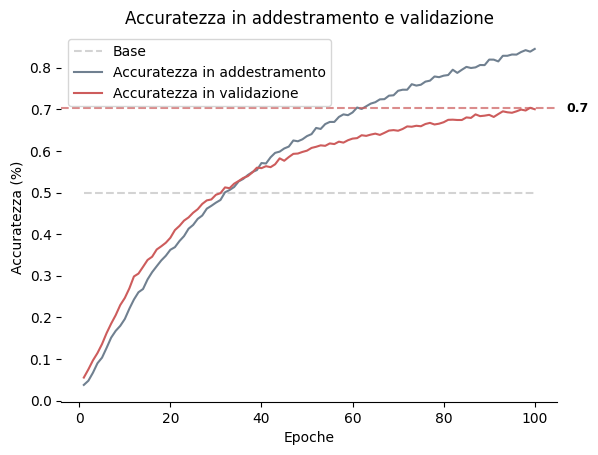

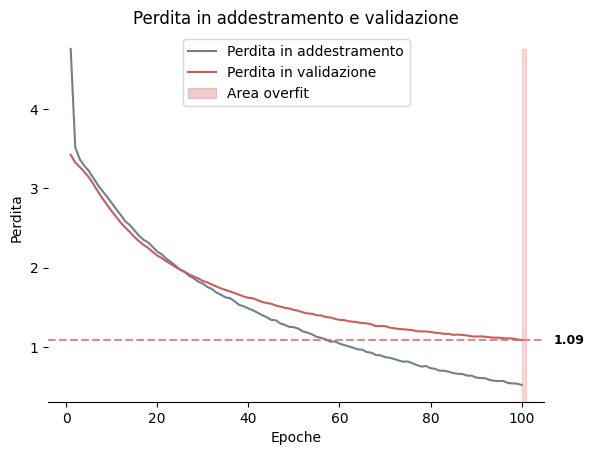

In [57]:
create_train_val_plot(tuned_improved_history.history)

Anche in questo caso la rete non ha raggiunto l'overfitting, nonostante ci fosse vicina, perciò avremmo potuto addestrarlo per un numero di epoche maggiore. 

D'altro canto le prestazioni non sono delle migliori. L'accuratezza maggiore raggiunge con difficoltà il **70%**. Probabilmente avremmo dovuto utilizzare un'altro **tasso di apprendimento**.

In [58]:
tuned_improved_best_model = tf.keras.models.load_model("bestmodels/rmsprop/tuned_improved_basic_model_mfcc.keras")
test_loss, test_acc = tuned_improved_best_model.evaluate(mfcc_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 0s 2ms/step - loss: 1.1160 - accuracy: 0.6939
Accuratezza: 0.694


In [60]:
evaluate_onnx_model("bestmodels/rmsprop/tuned_improved_basic_model_mfcc.onnx", mfcc_test_ds)

Accuratezza: 0.694


Di fatto l'accuratezza raggiuta nel set non raggiunge neppure la soglia del **70%**. 

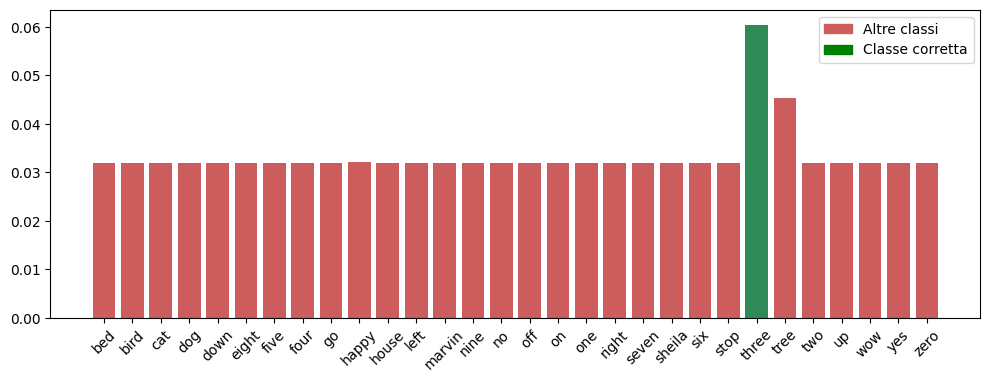

In [61]:
for audio, label in mfcc_test_ds:
    create_distribution_plot(tuned_improved_best_model, audio, label)
    break

Come prima è riuscito a predire correttamente la classe three, con dell'incertezza verso tree. Accettabile vista la somiglianza tra le parole. 

### Miglioramenti all'architettura del modello convolutivo
In questa ultima fase riguardante gli mfcc andremo ad addestrare il modello corrispondente alla sezione **miglioramenti all'architettura del modello** del notebook di riferimento.

In questo caso non è necessario implementare cambiamenti all'architettura del modello.

In [62]:
def residual_block(x, filters, pooling=False):
    residual = x

    x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    if pooling:
      x = tf.keras.layers.MaxPooling2D(pool_size=2, padding="same")(x)
      residual = tf.keras.layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
      residual = tf.keras.layers.Conv2D(filters, 1)(residual)

    x = tf.keras.layers.add([x, residual])
    return x

def bp_basic_model(input_shape):
    # input e pre processamento
    inputs = tf.keras.Input(shape=input_shape)
    
    x = residual_block(inputs, 32, pooling=True)
    x = residual_block(x, 64, pooling=True)
    x = residual_block(x, 128, pooling=True)
    x = residual_block(x, 256, pooling=True)
    x = residual_block(x, 256, pooling=False)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Livelli per la classificazione
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [63]:
for audio, label in mfcc_train_ds:
    bp_basic_model = bp_basic_model(audio.shape[1:])
    break

bp_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

bp_basic_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 98, 12, 1)]  0           []                               
                                                                                                  
 separable_conv2d_5 (SeparableC  (None, 98, 12, 32)  41          ['input_7[0][0]']                
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 98, 12, 32)  128         ['separable_conv2d_5[0][0]']     
 rmalization)                                                                                     
                                                                                            

Il numero di parametri, come per i filterbank, è rimasto invariato.

In [64]:
bp_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/rmsprop/bp_basic_model_mfcc.keras", save_best_only=True, monitor="val_loss")]
bp_model_history = bp_basic_model.fit(mfcc_train_ds, epochs=100, validation_data=mfcc_val_ds, callbacks=bp_basic_model_callbacks)

Epoch 1/100
243/243 [==============================] - 3s 8ms/step - loss: 4.5528 - accuracy: 0.0911 - val_loss: 3.0737 - val_accuracy: 0.1335
Epoch 2/100
243/243 [==============================] - 2s 8ms/step - loss: 2.8001 - accuracy: 0.2231 - val_loss: 2.8056 - val_accuracy: 0.2199
Epoch 3/100
243/243 [==============================] - 2s 8ms/step - loss: 2.2301 - accuracy: 0.3577 - val_loss: 2.2214 - val_accuracy: 0.3677
Epoch 4/100
243/243 [==============================] - 2s 8ms/step - loss: 1.8024 - accuracy: 0.4874 - val_loss: 1.7866 - val_accuracy: 0.4834
Epoch 5/100
243/243 [==============================] - 2s 8ms/step - loss: 1.4750 - accuracy: 0.5811 - val_loss: 1.4724 - val_accuracy: 0.5772
Epoch 6/100
243/243 [==============================] - 2s 9ms/step - loss: 1.2365 - accuracy: 0.6461 - val_loss: 1.5259 - val_accuracy: 0.5428
Epoch 7/100
243/243 [==============================] - 2s 9ms/step - loss: 1.0810 - accuracy: 0.6875 - val_loss: 1.2249 - val_accuracy: 0.6451

In [65]:
bp_model_history_df = convert_history_to_csv(bp_model_history)
bp_model_history_df.to_csv("model_histories/rmsprop/bp_model_history_mfcc.csv")

convert_model_to_onnx("bestmodels/rmsprop/bp_basic_model_mfcc.keras", (98, 12, 1))

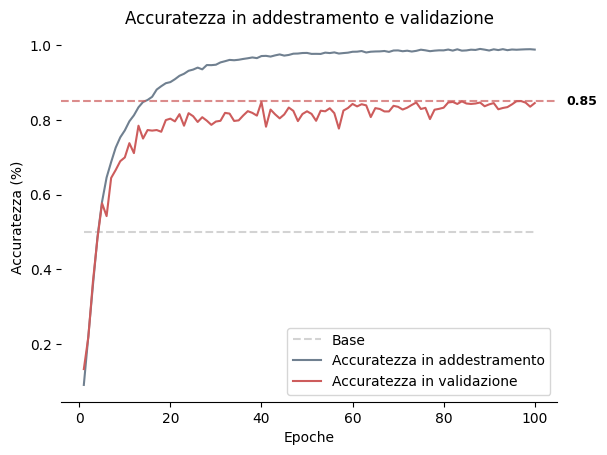

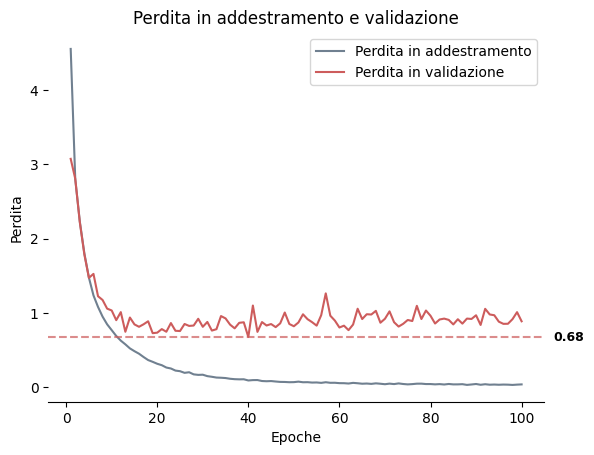

In [66]:
create_train_val_plot(bp_model_history.history, overfit=False)

In questo caso il modello è sotto certi aspetti leggermente migliorato rispetto a prima, ma continua ad avere delle prestazioni peggiori rispetto agli spettrogrammi e filterbanks.

In [67]:
best_bp_basic_model = tf.keras.models.load_model("bestmodels/rmsprop/bp_basic_model_mfcc.keras")
test_loss, test_acc = best_bp_basic_model.evaluate(mfcc_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 0s 2ms/step - loss: 0.7680 - accuracy: 0.8214
Accuratezza: 0.821


In [68]:
evaluate_onnx_model("bestmodels/rmsprop/bp_basic_model_mfcc.onnx", mfcc_test_ds)

Accuratezza: 0.821


Abbiamo ottenuto un'accuratezza del **82.1%**. A conferma di quanto detto prima, il modello risulta migliore.

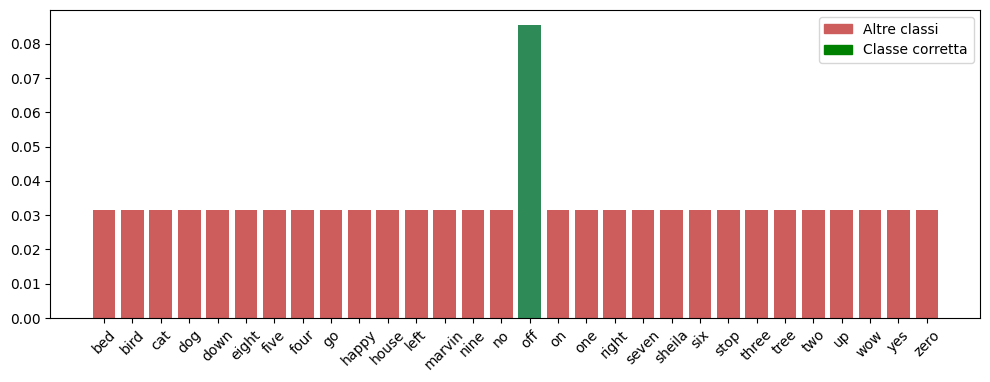

In [69]:
for audio, label in mfcc_test_ds:
    create_distribution_plot(best_bp_basic_model, audio, label)
    break

La decisione del modello in questo caso è nuovamente molto chiara.